Calculate correlations and motion-conditioned partial correlations among DAN pairs.

In [1]:
%reset -f
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

from disp import set_font_size


# EXPT = 'ASENSORY_AZ'
EXPT = 'CL_360_LOWFLOW_ACV'

DATA_DIR = os.path.join('data', EXPT)

DANS = {'G2': 'G2_avg', 'G3': 'G3_avg', 'G4': 'G4_avg', 'G5': 'G5_avg'}
# DANS = {'G2': 'G2_R', 'G3': 'G3_R', 'G4': 'G4_R', 'G5': 'G5_R'}
# DANS = {'G2': 'G2_L', 'G3': 'G3_L', 'G4': 'G4_L', 'G5': 'G5_L'}

T_WDW = 0.1

DT = 0.1

CORRS = [('G2', 'G3'), ('G2', 'G4'), ('G2', 'G5'), ('G3', 'G4'), ('G3', 'G5'), ('G4', 'G5')]
CORR_COLS = ['G2_G3', 'G2_G4', 'G2_G5', 'G3_G4', 'G3_G5', 'G4_G5']

SAVE_DIR = 'data/_RESULTS/PARTIAL_CORRS'


def downsample(x, t_wdw):
    """Downsample multivariate time-series data.
    
    :param x: dataframe with column 'Time'
    :param t_wdw: averaging window (in same units as t)
    """
    t = x['Time']
    
    # get time window starts and ends
    temp = np.arange(0, t.iloc[-1], t_wdw)
    t_start = temp[:-1]
    t_end = temp[1:]
    del temp
    
    x_d = pd.DataFrame(np.nan, index=range(len(t_start)), columns=x.columns)
    
    # loop through time windows
    for ctr, (t_start_, t_end_) in enumerate(zip(t_start, t_end)):
        # get time mask
        t_mask = (t_start_ <= t) & (t < t_end_)
        
        # store means
        x_d.iloc[ctr] = x[t_mask].mean(skipna=True)
    
    return x_d

# Load data

In [2]:
if DATA_DIR == 'data/ASENSORY_AZ':
    base = 'BigMAT.csv'
elif DATA_DIR == 'data/CL_360_LOWFLOW_ACV':
    base = 'clean.csv'
else:
    raise Exception

data = {}

print('Loading data from directory "{}"...'.format(DATA_DIR))
# loop through flies
for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    # loop through trials
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data matrix
        temp_0 = pd.read_csv(os.path.join(trial_path, base))
        temp_1 = temp_0[['Time', 'Motion'] + sorted(DANS.values())]  # select relevant cols
        data[trial] = temp_1.rename(columns={v: k for k, v in DANS.items()})  # rename DANs

print('Data loaded.')

Loading data from directory "data/CL_360_LOWFLOW_ACV"...
Data loaded.


# Calc full & partial correlations

In [3]:
full = pd.DataFrame([], index=data.keys(), columns=CORR_COLS).rename_axis('TRIAL')
partial_no_speed = pd.DataFrame([], index=data.keys(), columns=CORR_COLS).rename_axis('TRIAL')
partial_no_speed_no_dan = pd.DataFrame([], index=data.keys(), columns=CORR_COLS).rename_axis('TRIAL')

# loop over trials
for ctr, (trial, data_) in enumerate(data.items()):
    print('Calculating correlations for trial "{}" ({}/{})...'.format(trial, ctr+1, len(data)))
    
    # downsample data
    if T_WDW > DT:
        data_d = downsample(data_.dropna(), T_WDW)
    else:
        data_d = data_.dropna()

    # calc full correlations
    mat_full = data_d.corr()
    
    for x, y in CORRS:
        full.loc[trial]['{}_{}'.format(x, y)] = mat_full[x][y]
        
    # calc partial corrs with Motion subtracted
    for x, y in CORRS:
        # predict x & y using Motion predictor
        zs = ['Motion']
        
        x_y_hat = linear_model.LinearRegression().fit(data_d[zs], data_d[[x, y]]).predict(data_d[zs])
        
        # store correlation between x & y with predictions from z subtracted
        partial_no_speed.loc[trial]['{}_{}'.format(x, y)] = (data_d[[x, y]] - x_y_hat).corr()[x][y]
        
    # calc partial corrs with Motion and other dans subtracted
    for x, y in CORRS:
        # predict x & y using Motion + other DAN predictors
        zs = ['Motion'] + [k for k in ['G2', 'G3', 'G4', 'G5'] if k not in (x, y)]
        assert (len(zs) == 3) and (x not in zs) and (y not in zs)
        
        x_y_hat = linear_model.LinearRegression().fit(data_d[zs], data_d[[x, y]]).predict(data_d[zs])
        
        # store correlation between x & y with predictions from z subtracted
        partial_no_speed_no_dan.loc[trial]['{}_{}'.format(x, y)] = (data_d[[x, y]] - x_y_hat).corr()[x][y]

# save results
SAVE_PATH_FULL = os.path.join(
    SAVE_DIR, '{}_FULL_DEL_T_{}S.csv'.format(EXPT, T_WDW))
SAVE_PATH_PARTIAL_NO_SPEED = os.path.join(
    SAVE_DIR, '{}_PARTIAL_NO_SPEED_DEL_T_{}S.csv'.format(EXPT, T_WDW))
SAVE_PATH_PARTIAL_NO_SPEED_NO_DAN = os.path.join(
    SAVE_DIR, '{}_PARTIAL_NO_SPEED_NO_DAN_DEL_T_{}S.csv'.format(EXPT, T_WDW))

for save_path in [SAVE_PATH_FULL, SAVE_PATH_PARTIAL_NO_SPEED, SAVE_PATH_PARTIAL_NO_SPEED_NO_DAN]:
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

full.to_csv(SAVE_PATH_FULL)
partial_no_speed.to_csv(SAVE_PATH_PARTIAL_NO_SPEED)
partial_no_speed_no_dan.to_csv(SAVE_PATH_PARTIAL_NO_SPEED_NO_DAN)

Calculating correlations for trial "20170821.Fly1.1" (1/31)...
Calculating correlations for trial "20180131.Fly1.2" (2/31)...
Calculating correlations for trial "20180131.Fly7.3" (3/31)...
Calculating correlations for trial "20180120.Fly1.1" (4/31)...
Calculating correlations for trial "20170828.Fly2.2" (5/31)...
Calculating correlations for trial "20180131.Fly8.1" (6/31)...
Calculating correlations for trial "20180201.Fly3.2" (7/31)...
Calculating correlations for trial "20180201.Fly3.4" (8/31)...
Calculating correlations for trial "20180131.Fly8.2" (9/31)...
Calculating correlations for trial "20180120.Fly1.2" (10/31)...
Calculating correlations for trial "20180131.Fly8.4" (11/31)...
Calculating correlations for trial "20180131.Fly9.3" (12/31)...
Calculating correlations for trial "20170826.Fly4.1" (13/31)...
Calculating correlations for trial "20170828.Fly4.3" (14/31)...
Calculating correlations for trial "20170828.Fly2.6" (15/31)...
Calculating correlations for trial "20170826.Fly7

# Make plots

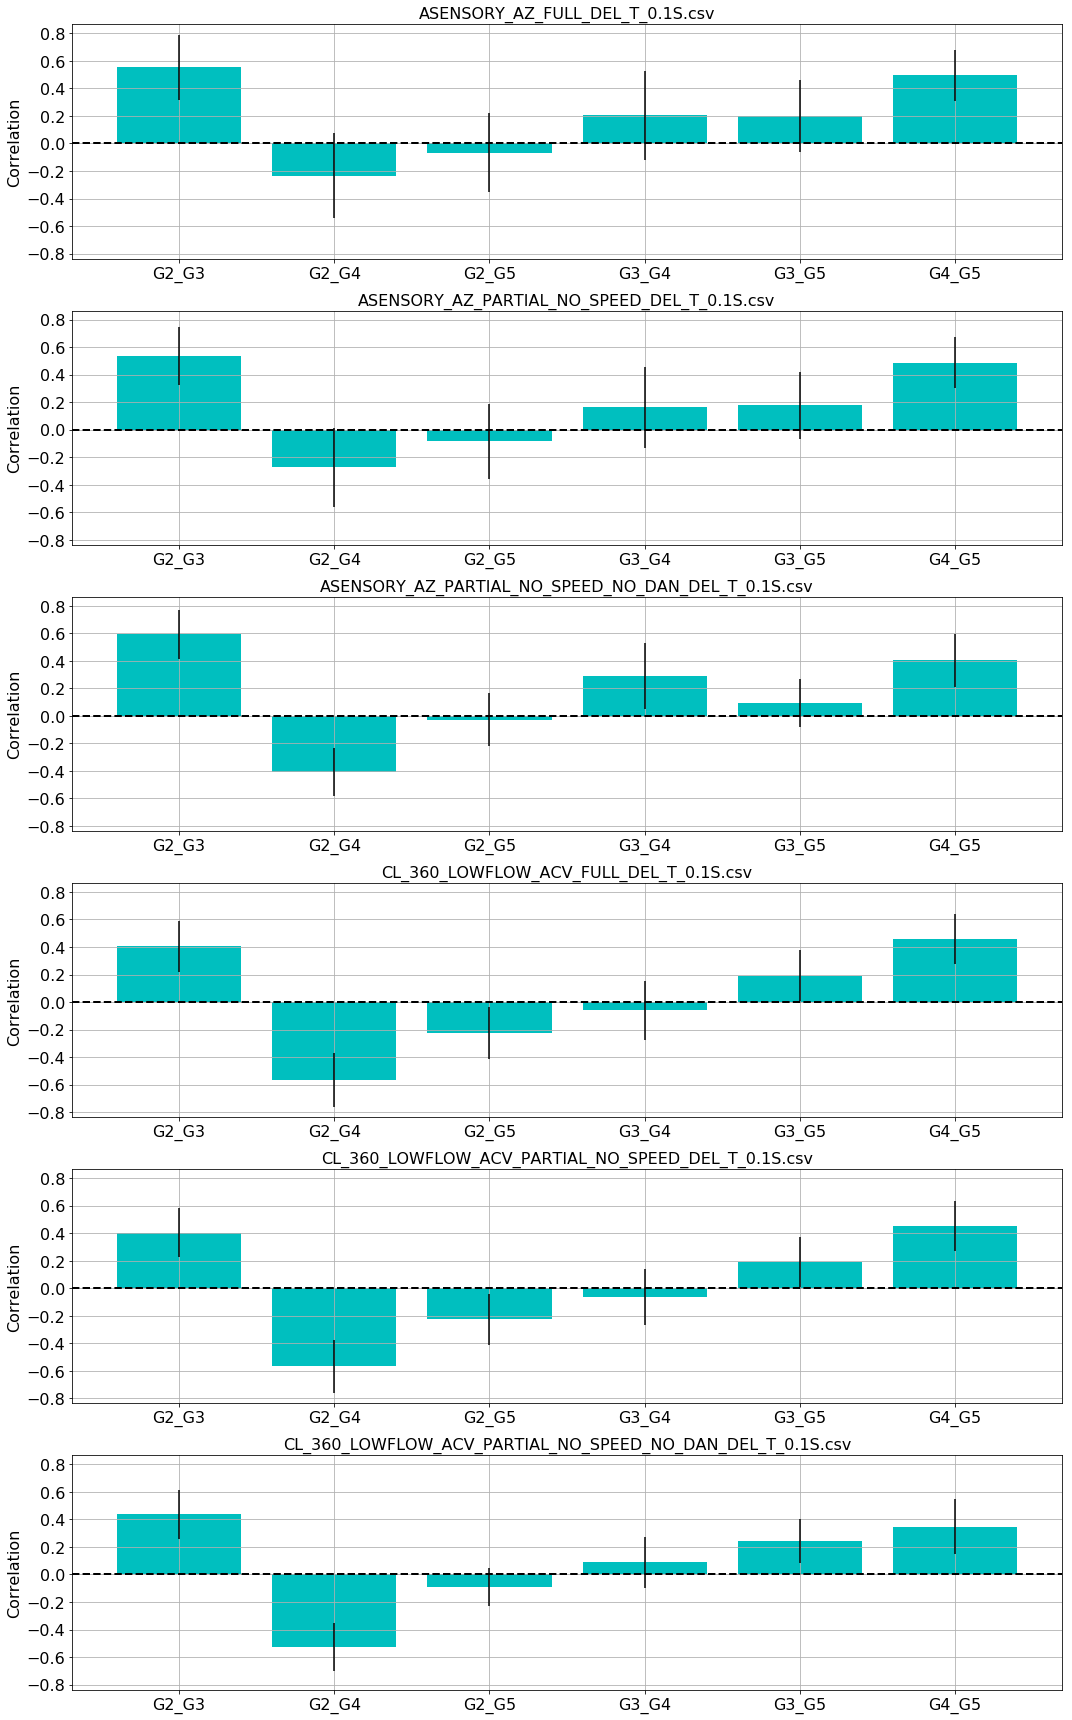

In [4]:
%reset -f
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from disp import set_font_size


LOAD_DIR = 'data/_RESULTS/PARTIAL_CORRS'

csvs = sorted([f_name for f_name in os.listdir(LOAD_DIR) if f_name.endswith('.csv')])

fig, axs = plt.subplots(
    len(csvs), 1, figsize=(15, 4*len(csvs)), sharey=True,
    tight_layout=True, squeeze=False)

for csv, ax in zip(csvs, axs[:, 0]):
    data = pd.read_csv(os.path.join(LOAD_DIR, csv), index_col=0)
    
    ax.bar(range(len(data.columns)), data.mean(), align='center', width=.8, yerr=data.std(), color='c')
    
    ax.axhline(0, lw=2, color='k', ls='--')
    ax.set_xticks(range(len(data.columns)))
    ax.set_xticklabels(data.columns)
    
    ax.set_ylabel('Correlation')
    ax.set_title(csv)
    
    ax.grid()
    set_font_size(ax, 16)

In [5]:
fig.savefig(os.path.join(LOAD_DIR, 'plot_rkp.pdf'))